In [2]:
import graphviz as gv
from IPython.display import Image
from pydantic.dataclasses import dataclass
from dataclasses import field


In [3]:
def display_g(g):
    display(Image(filename=g.render(format="png")))

In [20]:
class Visitor:
    def visit(self, op: "Op"): ...
class Node:
    def accept(self, v: Visitor): ...

@dataclass(kw_only=True)
class Op(Node):
    catch: dict[str, str]|None = None

    def accept(self, v: Visitor):
        v.visit(self)


@dataclass(kw_only=True)
class Object(Op):
    name: str
    cls: str

    def accept(self, v: Visitor):
        v.visit(self)

@dataclass(kw_only=True)
class Function(Op):
    name: str
    ops: list[Op]

    def accept(self, v: Visitor):
        v.visit(self)
        for op in self.ops:
            op.accept(v)


program = Function(name="Task", ops=[Function(name="Drive", ops=[Object(name="engine", cls="Engine")], catch={"_": "Failed to drive"})])


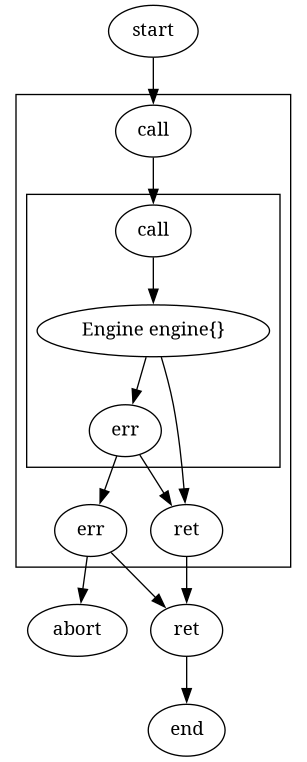

In [25]:
def key(op: Op, extra:str|None=None):
    k = f"{id(op)}"
    if extra: k = extra + "_" + k
    return k

class Cxx:
    def __init__(self, op: Op):
        self.root = gv.Digraph()
        self.root.node(curr:="start", "start")
        self.root.node(err:="err", "abort")
        last = self.visit_Op(op, self.root, curr, err)
        self.root.node(end:="end", "end")
        self.root.edge(last, end)
   
    def visit_Op(self, op: Op, g: gv.Digraph, last:str, err:str) -> str:
        match op:
            case Function():
                g.node(curr:=key(op), f"call")
                g.edge(last, curr)
                last = curr
                g.node(cerr:=key(op, "err"), f"err")
                
                with g.subgraph(name=key(op, "cluster"), comment=op.name) as cg:
                    for cop in op.ops:
                        last = self.visit_Op(cop, cg, last, cerr)
                
                g.node(ret:=key(op, "ret"), f"ret")
                g.edge(last, ret)
                g.edge(cerr, ret)
                g.edge(cerr, err)
                return ret
            case Object():
                g.node(curr:=key(op), f"{op.cls} {op.name}{{}}")
                g.edge(last, curr)
                g.edge(curr, err)
                return curr
            case _:
                raise NotImplemented

cxx = Cxx(program)
display_g(cxx.root)

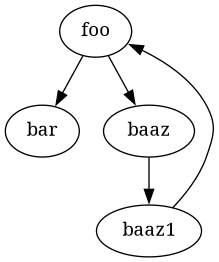

In [7]:

g = gv.Digraph()
g.edge("foo", "bar", weight="1")
g.edge("foo", "baaz", weight="1")
g.edge("baaz", "baaz1", weight="1")
g.edge("baaz1", "foo", weight="0")

display_g(g)